# Hipótesis 4

Probando otros métodos para validar la hipótesis 4.

## Preparación del entorno

In [ ]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

GOLD_DATA_PATH = os.path.join("..", "..", "data/gold/")

## Datos mediana

Los datos que se usarán están en el dataset de la tarjeta de datos 4: `data_card_4_df.csv`. En los que se usa la mediana de la edad.

In [ ]:
# Cargar de los datos
df4 = pd.read_csv(GOLD_DATA_PATH + "data_card_4_df.csv", sep=";", encoding = 'latin')


In [ ]:
# Formateado de la tabla
df4 = df4.drop(columns=["Unnamed: 0"])
df4.set_index("Provincias", inplace=True)
df4.head(3)

### Estandarización de los datos

Cada variable tiene una escala diferente, por lo que es necesario estandarizar los datos para que todas tengan la misma importancia en el análisis.
Se ha elegido el MinMaxScaler para que los valores estén entre 0 y 1, intentando modificar lo menos posible la distribución de los datos.


In [ ]:
# Escalado de los datos a un rango de 0 a 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df4)
df4_scaled = pd.DataFrame(scaled_data, columns=df4.columns)

df4_scaled.head(3)

### Análisis de componentes principales (PCA)

Para reducir la dimensionalidad de los datos y poder visualizarlos, se aplicará PCA. La representación se hará tanto en 2D como en 3D.

In [ ]:
# Calculo de PCA
from sklearn.decomposition import PCA

estimator = PCA(n_components=3)
X_pca = estimator.fit_transform(scaled_data)

print("Porcentaje de varianza explicado por cada componente:\n", estimator.explained_variance_ratio_)
pd.DataFrame(np.matrix.transpose(estimator.components_), index=df4.columns)

In [ ]:
#Representación 2D
fig, ax = plt.subplots()
ax.scatter(X_pca[:,0], X_pca[:,1], s=50)

# anotación 
for i in range(0, len(X_pca)):
    ax.annotate(df4.iloc[i, :].name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)

In [ ]:
# Representación 3D
import plotly.express as px

fig = px.scatter_3d(df4, x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2], color=df4.index, color_discrete_sequence=px.colors.qualitative.Alphabet)
fig.show()

## Modelado

### Clustering jerárquico

In [ ]:
# Dendrograma probando con distintos métodos

methods = ['single', 'complete', 'average', 'ward']
plt.figure(figsize=(16, 10))
for method in methods:
    link_matrix = linkage(scaled_data, method=method, metric='euclidean')
    plt.subplot(2, 2, methods.index(method) + 1)
    dendrogram(link_matrix, labels=df4.index)
    plt.title('Dendrograma ' + method.upper())

plt.tight_layout()
plt.show()

El método ward es el que mejor se ajusta a los datos, por lo que se usará para el clustering jerárquico. Este método minimiza la distancia intra-cluster y maximiza la distancia inter-cluster.

In [ ]:
# Selección del método ward
link_matrix_avg = linkage(scaled_data, method='ward', metric='euclidean')

plt.figure(figsize=(8, 5))
dendrogram(link_matrix_avg, labels=df4.index)
plt.title('Dendrograma WARD')
plt.show()

In [ ]:
# selección de número de clusters n = 2
n = 2
clusters = fcluster(link_matrix_avg, t=n, criterion='maxclust')
coef = silhouette_score(df4_scaled, clusters)
print(f"Coeficiente de silhouette para {n} clusters: {coef:.4f}")

In [ ]:
# visualización del resultado
plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], s=50, c=clusters, cmap='plasma_r')

# nombres de las provincias 
for i in range(0, len(X_pca)):
    plt.annotate(df4.iloc[i, :].name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)

handles, labels = scatter.legend_elements()
legend = plt.legend(handles, labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
import plotly.express as px

fig = px.scatter_3d(df4, x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2], color=clusters, color_continuous_scale='plasma_r')
fig.show()

## Resultados

Mapa de la península con las provincias coloreadas según el cluster al que pertenecen.   

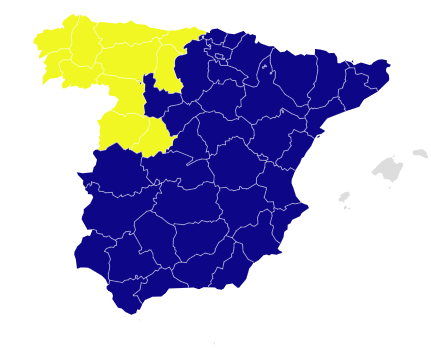

**Extra**

Este sería el resultado si se hubieran elegido 3 clusters. Es difícil interpretarlo, ya que ni siquiera coincide con los diferentes climas de la península ni con la división por ciudades más grandes.


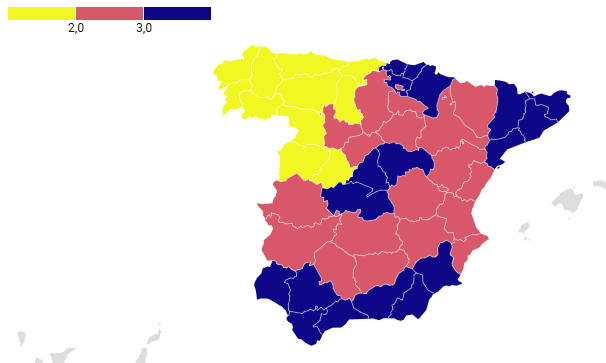

In [ ]:
clusters = fcluster(link_matrix_avg, t=3, criterion='maxclust')

# visualización del resultado
plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], s=50, c=clusters, cmap='plasma_r')

handles, labels = scatter.legend_elements()
legend = plt.legend(handles, labels, title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

----------------

## Datos K-Means

Usando la edad media.

In [ ]:
# cargar los datos
df1 = pd.read_csv(GOLD_DATA_PATH + "data_card_1_df.csv", sep=";", encoding = 'latin')

df4 = pd.read_csv(GOLD_DATA_PATH + "data_card_4_df.csv", sep=";", encoding = 'latin')
df4.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
df4.drop(columns=["Mediana edad"], inplace=True)

In [ ]:
# sustituir la variable edad
df4 = pd.concat([df4, df1['Edad media']], axis=1)
df4.set_index('Provincias', inplace=True)

In [ ]:
df4.head()

## Estandarización de los datos

Cada variable tiene una escala diferente, por lo que es necesario estandarizar los datos para que todas tengan la misma importancia en el análisis.
Se ha elegido el MinMaxScaler para que los valores estén entre 0 y 1, intentando modificar lo menos posible la distribución de los datos.

In [ ]:
# Escalado de los datos a un rango de 0 a 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df4)
df4_scaled = pd.DataFrame(scaled_data, columns=df4.columns, index=df4.index)

df4_scaled.head(3)

## Análisis de componentes principales

Para reducir la dimensionalidad de los datos y poder visualizarlos, se aplicará PCA con 2 componentes.

In [ ]:
# Calculo de PCA
from sklearn.decomposition import PCA

estimator = PCA(n_components=2)
X_pca = estimator.fit_transform(scaled_data)

print("Porcentaje de varianza explicado por cada componente:\n", estimator.explained_variance_ratio_)
pd.DataFrame(np.matrix.transpose(estimator.components_), index=df4.columns)

In [ ]:
#Representación 2D
fig, ax = plt.subplots()
ax.scatter(X_pca[:,0], X_pca[:,1], s=50)

# anotación 
for i in range(0, len(X_pca)):
    ax.annotate(df4.iloc[i, :].name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)
ax.set_title("Representación 2D de los datos")

## Modelado

### K-means

El algoritmo de K-means es un algoritmo de clustering no jerárquico que divide los datos en K clusters. Se ha elegido K=2 para comparar los resultados con el clustering jerárquico.

In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

distortions = []
silhouettes = []
# visualizar diferentes configuraciones de k
for i in range(2, 11):
    km = KMeans(n_clusters = i, init = 'k-means++',random_state = 30)
    labels = km.fit_predict(X_pca)
    distortions.append(km.inertia_)
    silhouettes.append(metrics.silhouette_score(scaled_data, labels))

In [ ]:
# distorsión de los clusters, visualizar el codo
plt.plot(range(2,11), distortions, marker='o')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()
# el k óptimo es 4

In [ ]:
#plot Silhouette score
plt.plot(range(2,11), silhouettes, marker='o')
plt.xlabel('K')
plt.ylabel('Silhouette score')
plt.show()

In [ ]:
k = 2
km = KMeans(k, init = "k-means++", random_state = 30)

y_km = km.fit_predict(X_pca)

In [ ]:
print("Coeficiente de Silhouette: ",silhouette_score(scaled_data, y_km))
print("Distorsión: ", km.inertia_)

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, s=50)
# Plot los centroides
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], c='red', s=70, marker='x', label='Centroides')

for i in range(len(X_pca)):
    plt.annotate(df4.iloc[i, :].name, (X_pca[i, 0], X_pca[i, 1]), fontsize=8)
plt.legend()
plt.title("Kmeans")
plt.show()

------------

## Clasificación manual

In [ ]:
norte=['Araba/Álava', 'Asturias', 'Barcelona', 'Bizkaia', 'Burgos', 'Cantabria', 'Coruña, A', 'Gipuzkoa', 'Girona', 'Guadalajara', 'Huesca', 'León', 'Lleida', 'Lugo', 'Navarra', 'Ourense', 'Palencia', 'Pontevedra', 'Rioja, La', 'Salamanca', 'Segovia', 'Soria', 'Tarragona', 'Teruel', 'Valladolid', 'Zamora', 'Zaragoza', 'Ávila']

df4['Grupo'] = ['Norte' if x in norte else 'Sur' for x in df4.index]

In [ ]:
df4.head()

In [ ]:
df4.groupby('Grupo').mean()